In [1]:
# See how much memory is used by OS initially.
# Then substract this value from later mem used, to obtain mem used by scripts.
import psutil
GB_UNIT = 1000*1024**2
MB_UNIT = GB_UNIT/1e3
OS_MEM = psutil.virtual_memory().used
print(OS_MEM/GB_UNIT)


from shared.preface import *
import shared.functions as fct


# Initialize parameters and files.
PRE = PRE(
    sim='L012N376', 
    z0_snap=36, z4_snap=13, DM_lim=10000,
    sim_dir=SIM_ROOT, sim_ver=SIM_TYPE,
    phis=10, thetas=10, vels=100,
    pre_CPUs=6, sim_CPUs=6, mem_lim_GB=12
)


TEMP_DIR = f'X_tests'

mass_gauge = 12.0
mass_range = 0.6
size = 1

hname = f'1e+{mass_gauge}_pm{mass_range}Msun'
fct.halo_batch_indices(
    PRE.Z0_STR, mass_gauge, mass_range, 'halos', size, 
    hname, PRE.SIM_DIR, TEMP_DIR
)
halo_batch_IDs = np.load(f'{TEMP_DIR}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{TEMP_DIR}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('********Number density band********')
print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)
print('***********************************')

2.40987109375
********************* Initialization *********************
# Initial conditions for neutrinos:
PHIs = 10, THETAs=10, Vs=100
Total neutrinos: 10000
# Simulation parameters:
Simulation box: L012N376
Snapshot from 0036 (z=0) to 0013 (z=4)
Pre/Sim CPUs 6/6
DM limit for cells: 10000
# File management:
Box files directory: 
 /home/fabian/ownCloud/snellius/L012N376/DMONLY/SigmaConstant00
Output directory: 
 /home/fabian/my_github_projects/neutrino_clustering_V2/L012N376/DMONLY/SigmaConstant00
**********************************************************
********Number density band********
Halo batch params (Rvir,Mvir,cNFW):
[[195.00028262  11.89848321  13.2646342 ]]
***********************************


In [2]:
# =============================================== #
# Run precalculations for selected halo in batch. #
# =============================================== #

halo_j = 0
halo_ID = halo_batch_IDs[halo_j]

halo_rvir = halo_batch_params[halo_j, 0]
halo_Mvir = halo_batch_params[halo_j, 1]
halo_cNFW = halo_batch_params[halo_j, 2]

# Generate progenitor index array for current halo.
splits = re.split('/', SIM_TYPE)
MTname = f'{PRE.SIM}_{splits[0]}_{splits[1]}'
proj_IDs = fct.read_MergerTree(PRE.OUT_DIR, MTname, halo_ID)


j = 0
snap = PRE.NUMS_SNAPS[::-1][0]
proj_ID = proj_IDs[0]

proj_ID = int(proj_ID)

# Output halo progress.
print(f'halo {halo_j+1}/{halo_num} ; snapshot {snap}')

# --------------------------- #
# Read and load DM positions. #
# --------------------------- #

IDname = f'origID{halo_ID}_snap_{snap}'
fct.read_DM_halo_index(
    snap, proj_ID, IDname, PRE.SIM_DIR, TEMP_DIR
)
DM_raw = np.load(f'{TEMP_DIR}/DM_pos_{IDname}.npy')
DM_particles = len(DM_raw)


# ---------------------- #
# Cell division process. #
# ---------------------- #

# Initialize grid.
snap_GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(snap_GRID_L, snap_GRID_L)
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)
del DM_raw

# Cell division.
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, snap_GRID_L, PRE.DM_LIM, None, TEMP_DIR, IDname
)
del DM_pos_for_cell_division


# Load files from cell division.
fin_grid = np.load(f'{TEMP_DIR}/fin_grid_{IDname}.npy')
DM_count = np.load(f'{TEMP_DIR}/DM_count_{IDname}.npy')
cell_com = np.load(f'{TEMP_DIR}/cell_com_{IDname}.npy')
cell_gen = np.load(f'{TEMP_DIR}/cell_gen_{IDname}.npy')
print(fin_grid.shape)

# --------------------------------------------- #
# Calculate gravity grid (in batches of cells). #
# --------------------------------------------- #
cell_coords = np.squeeze(fin_grid, axis=1)
cells = len(cell_coords)

halo 1/1 ; snapshot 0036
(267, 1, 3)


Following cell shows the reason, why beyond the virial radius, the ratio of the cell gravity and NFW has a different value than one. NFW uses the virial mass, whereas my implementation uses the total mass of all DM particles of the halo.

In [3]:
mass1 = 10**halo_Mvir
mass2 = PRE.DM_SIM_MASS*DM_particles/Msun
print(mass2/mass1)
# The last ratio is exactly what we can see (outside the virial radius) with 
# the gravity_comparison_NFW function below.

0.8305812023101771


## Short-range gravity.

In [4]:
def chunksize_short_range(cells, DM_tot, max_DM_lim, core_mem_MB):

    # note: mem_MB specific to peak memory usage in cell_gravity_short_range.
    # -> Peak memory after calculation of ind_2D,ind_3D,etc. sorting arrays.

    elem = 8                               # 8 bytes for standard np.float64
    mem_type0 = cells*3 * elem             # for list to ndarray of cell_coords
    mem_type1 = cells*DM_tot * elem        # for ind_2D
    mem_type2 = cells*DM_tot*3 * elem      # for DM_pos_sync, ind_3D, DM_sort
    mem_type3 = cells*max_DM_lim*3 * elem  # for DM_in

    mem_MB = (mem_type0+mem_type1+(3*mem_type2)+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize


def batch_generators_short_range(cell_coords, cell_gen, chunksize):

    cells = len(cell_coords)

    batches = math.ceil(cells/chunksize)
    batch_arr = np.arange(batches)

    cell_chunks = chunks(chunksize, cell_coords)
    cgen_chunks = chunks(chunksize, cell_gen)
    
    return batch_arr, cell_chunks, cgen_chunks


def cell_gravity_short_range(
    cell_coords_in, cell_gen, init_GRID_S,
    DM_pos, DM_lim, DM_sim_mass, smooth_l,
    out_dir, b_id
):

    cell_coords = np.expand_dims(np.array(cell_coords_in), axis=1)
    cell_gen = np.array(cell_gen)

    # Center all DM positions w.r.t. cell center.
    # DM_pos already in shape = (1, DM_particles, 3)
    DM_pos_sync = np.repeat(DM_pos, len(cell_coords), axis=0)
    DM_pos_sync -= cell_coords

    # Cell lengths to limit DM particles. Limit for the largest cell is 
    # GRID_S/2, not just GRID_S, therefore the cell_gen+1 !
    cell_len = np.expand_dims(init_GRID_S/(2**(cell_gen+1)), axis=1)

    # Select DM particles inside each cell based on cube length generation.
    DM_in_cell_IDs = np.asarray(
        (np.abs(DM_pos_sync[:,:,0]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,1]) < cell_len) & 
        (np.abs(DM_pos_sync[:,:,2]) < cell_len)
    )
    del cell_gen, cell_len

    # Set DM outside cell to nan values.
    DM_pos_sync[~DM_in_cell_IDs] = np.nan
    
    # Save the DM IDs, such that we know which particles are in which cell.
    # This will be used in the long-range gravity calculations.
    # np.save(f'{out_dir}/batch{b_id}_DM_in_cell_IDs.npy', DM_in_cell_IDs)
    del DM_in_cell_IDs

    # Sort all nan values to the bottom of axis 1, i.e. the DM-in-cell-X axis 
    # and truncate array based on DM_lim parameter. This simple way works since 
    # each cell cannot have more than DM_lim.
    ind_2D = DM_pos_sync[:,:,0].argsort(axis=1)
    ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)
    DM_sort = np.take_along_axis(DM_pos_sync, ind_3D, axis=1)
    DM_in = DM_sort[:,:DM_lim*SHELL_MULTIPLIERS[-1],:]

    # note: Memory peaks here, due to these arrays:
    # print(DM_pos_sync.shape, ind_2D.shape, ind_3D.shape, DM_sort.shape, DM_in.shape)
    # mem_inc = gso(cell_coords)+gso(DM_pos_sync)+gso(ind_2D)+gso(ind_3D)+gso(DM_sort)+gso(DM_in)
    # print('MEM_PEAK:', mem_inc/1e6)
    del DM_pos_sync, ind_2D, ind_3D, DM_sort

    np.save(f'{out_dir}/batch{b_id}_DM_in_cells.npy', DM_in)

    # Calculate distances of DM and adjust array dimensionally.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_in**2, axis=2)), axis=2)

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.
    # eps = smooth_l

    # nan values to 0 for numerator, and 1 for denominator to avoid infinities.
    quot = np.nan_to_num(cell_coords - DM_in, copy=False, nan=0.0) / \
        np.nan_to_num(
            np.power((DM_dis**2 + eps**2), 3./2.), copy=False, nan=1.0
        )
    
    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.sum(quot, axis=1)    
    np.save(f'{out_dir}/batch{b_id}_short_range.npy', derivative)


# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine short-range chuncksize based on available memory and cells.
chunksize_sr = chunksize_short_range(
    cells, DM_particles, PRE.DM_LIM*SHELL_MULTIPLIERS[-1], core_mem_MB
)

# Split workload into batches (if necessary).
batch_arr, cell_chunks, cgen_chunks = batch_generators_short_range(
    cell_coords, cell_gen, chunksize_sr
)

single = False

if single:
    # Memory profile the short-range gravity function.
    in1 = next(cell_chunks)
    in2 = next(cgen_chunks)
    in3 = batch_arr[0]

    cell_gravity_short_range(
        in1, in2, snap_GRID_L,
        DM_pos, PRE.DM_LIM, PRE.DM_SIM_MASS, PRE.SMOOTH_L, 
        TEMP_DIR, in3
    )

else:
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_short_range, 
            cell_chunks, cgen_chunks, repeat(snap_GRID_L), repeat(DM_pos), 
            repeat(PRE.DM_LIM), repeat(PRE.DM_SIM_MASS), repeat(PRE.SMOOTH_L), 
            repeat(TEMP_DIR), batch_arr
        )



# Combine short-range batch files.
dPsi_short_range_batches = [
    np.load(f'{TEMP_DIR}/batch{b}_short_range.npy') for b in batch_arr
]
dPsi_short_range = np.array(
    list(chain.from_iterable(dPsi_short_range_batches))
)
np.save(
    f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy', 
    dPsi_short_range
)

Per core mem (GB): 1.9770182291666667


In [5]:
#TODO: create array, which only contains the IDs of the DM particles inside each cell. So for the example halo here with ~520k particles, we can string together an array containing only the IDs (ranging from 0 to ~520k-1), which are True in the DM_in_cell_IDs array. With the DM_count array, we know which chunk out of this long array to take for each cell!



In [7]:
# DM_in_cell_IDs_l = []
# for b_id in batch_arr:
#     DM_in_cell_IDs_l.append(
#         np.load(f'{TEMP_DIR}/batch{b_id}_DM_in_cell_IDs.npy')
#     )
# DM_in_cell_IDs_np = np.array(list(chain.from_iterable(DM_in_cell_IDs_l)))
# print(DM_in_cell_IDs_np.shape)
# print(gso(DM_in_cell_IDs_np)/1e6)

## Long-range gravity.

In [17]:
def chunksize_long_range(cells, core_mem_MB):
    
    # note: mem_MB specific to peak memory usage in cell_gravity_long_range.
    # -> Peak memory after calculation of derivative.

    elem = 8                          # 8 bytes for standard np.float64
    mem_type1 = 3*elem                # for derivative
    mem_type2 = cells*3*elem          # for quot
    mem_type3 = cells*elem            # for DM_count_sync

    mem_MB = (mem_type1+mem_type2+mem_type3)/1.e6

    batches = 1
    while mem_MB >= 0.95*core_mem_MB:
        mem_MB *= batches
        batches += 1
        mem_MB /= batches

    chunksize = math.ceil(cells/batches)

    return chunksize
    

def batch_generators_long_range(
    cell_coords, com_coords, 
    DM_counts, #DM_in_cell_IDs,
    chunksize 
):
    cells = len(cell_coords)
    cell_nums = np.arange(cells)

    batches = math.ceil(cells/chunksize)

    # Arrays used for naming files.
    id_arr = np.array([idx+1 for idx in cell_nums for _ in range(batches)])
    batch_arr = np.array([b+1 for _ in cell_nums for b in range(batches)])

    # Coord of cell, for which long-range gravity gets calculated.
    coord_arr = np.array([cc for cc in cell_coords for _ in range(batches)])

    # Chunks for DM_count array, as a generator for all cells.
    count_gens = (c for _ in cell_nums for c in chunks(chunksize, DM_counts))
    count_chain = chain(gen for gen in count_gens)

    # Chunks for cell_com array, as a generator for all cells.
    com_gens = (c for _ in cell_nums for c in chunks(chunksize, com_coords))
    com_chain = chain(gen for gen in com_gens)

    return id_arr, batch_arr, coord_arr, count_chain, com_chain
    

def cell_gravity_long_range(
    c_id, b_id, cellX_coords, 
    DM_count, cell_com, 
    DM_sim_mass, smooth_l, out_dir
):

    # Distances between cell centers and cell c.o.m. coords.
    com_dis = np.expand_dims(
        np.sqrt(np.sum((cellX_coords-cell_com)**2, axis=1)), axis=1
    )

    # Offset DM positions by smoothening length of Camila's simulations.
    eps = smooth_l / 2.

    # Long-range gravity component for each cell (including itself for now).
    quot = (cellX_coords-cell_com)/np.power((com_dis**2 + eps**2), 3./2.)
    del com_dis

    # Set self-gravity to zero.
    DM_count_sync = np.expand_dims(DM_count, axis=1)
    DM_count_sync[c_id-1, :] = 0.

    # note: Minus sign, s.t. velocity changes correctly (see GoodNotes).
    derivative = -G*DM_sim_mass*np.sum(DM_count_sync*quot, axis=0)

    # note: Memory peaks here, due to these arrays:
    # print(quot.shape, DM_count_sync.shape, derivative.shape)
    # mem_inc = gso(quot)+gso(DM_count_sync)+gso(derivative)
    # print(mem_inc/1e6)
    del quot, DM_count_sync

    np.save(f'{out_dir}/cell{c_id}_batch{b_id}_long_range.npy', derivative)


def cell_gravity_long_range_quadrupole(
    c_id, b_id, cellC_coords, cell_com,
    DM_pos, DM_count, #DM_sim_mass, DM_lim, 
    # smooth_l, out_dir
):

    cell_com = np.array(cell_com)
    DM_count = np.array(DM_count)

    #PRE-TODO: check all input shapes.
    print(c_id, b_id, cellC_coords.shape, cell_com.shape)
    print(DM_pos.shape, DM_count.shape)


    # Pre checks.
    # 1. Determine which cells are close enough to use multipole expansion for.
    cellX_sync = np.expand(
        np.repeat(cellC_coords, len(cell_com), axis=0), axis=1
    )
    cellX_sync -= cell_com # shape (len(cell_com), 1, 3)


    cell_len = snap_GRID_L/(2**(cell_gen+1))


    # Distance of cellX to other cell_com's.
    r_c = np.sqrt(np.sum(cellX_sync**2, axis=2))
    theta = cell_len / r_c
    theta_crit = ... #? how do we determine critical angle?

    multipole_cells = cell_com[theta >= theta_crit]

    # 2. For these cells, repeat routine of selecting DM particles in those 
    # cells. This might be more efficient than carrying over DM_in_cell_IDs 
    # from the short-range calculations.
    # (i.e. np.repeat(DM_pos, X, axis=0), where X is for close enough cells)




    '''
    # 1. Create array containing DM for each cell present in batch. Use 
    # DM_in_cell_IDs (saved in short-range gravity fct.).
    #! Input DM_pos must have shape (1, DM_particles, 3), like in short-range.
    DM_pos_sync = np.repeat(DM_pos, len(cell_com), axis=0)
    DM_pos_sync[~DM_in_cell_IDs] = np.nan

    # Sort nan values to the bottom and truncate array to largest DM_LIM.
    # (DM_LIM*SHELL_MULTIPLIERS[-1] see routine in short-range gravity)
    ind_2D = DM_pos_sync[:,:,0].argsort(axis=1)
    ind_3D = np.repeat(np.expand_dims(ind_2D, axis=2), 3, axis=2)
    DM_sort = np.take_along_axis(DM_pos_sync, ind_3D, axis=1)
    DM_in = DM_sort[:,:DM_lim*SHELL_MULTIPLIERS[-1],:]
    del DM_pos_sync

    # 2. Calculate distances of all DM in cell J from c.o.m. coord of cell J.
    # -> this is the r_j needed for the quadrupole term.
    DM_dis = np.expand_dims(np.sqrt(np.sum(DM_in**2, axis=2)), axis=2)

    # 3. Center DM in cell J on c.o.m. coords. of cell J. Repeat for each cell.
    # -> these are the coords. x_{a,j} needed for the quadrupole term.
    DM_in -= cell_com

    # 4. Create array, where cellX_coords are centered on a c.o.m. coord. of a 
    # different cell J. 
    # -> these are the coords. x_a needed for the quadrupole term.
    #? shape of cellX_coords is (1,3) ?
    cellX_sync = np.expand(
        np.repeat(cellX_coords, len(cell_com), axis=0), axis=1
    )
    cellX_sync -= cell_com # shape (len(cell_com), 1, 3)

    # Distance of cellX to other cell_com's.
    r_c = np.sqrt(np.sum(cellX_sync**2, axis=2))  # shape (len(cell_com), 1)

    # 5. Calculate terms, where a=b and a!=b, seperately. Summation over a,b 
    # corresponds to sum over axis=2.
    a_eq_b_orig = np.sum((3*DM_in**2 - DM_dis**2)*cellX_sync**2, axis=2)

    x_1j, x_2j, x_3j = DM_in[...,0], DM_in[...,1], DM_in[...,2]
    x_1, x_2, x_3 = cellX_sync[...,0], cellX_sync[...,1], cellX_sync[...,2]
    a_neq_b_orig = 3*2*(
        x_1j*x_2j*x_1*x_2 + x_2j*x_3j*x_2*x_3 + x_3j*x_1j*x_3*x_1
    )  # sum explicitly written out, instead of a np.sum(..., axis=2)


    a_eq_b_deriv = np.sum((3*DM_in**2 - DM_dis**2)*cellX_sync, axis=2)

    a_neq_b_deriv = 3*(x_1j*x_2j*x_2 + x_2j*x_3j*x_3 + x_3j*x_1j*x_1)

    # 6. Summing over j in cell J is a summation over axis=1.
    sum_Ja_orig = np.sum(a_eq_b_orig + a_neq_b_orig, axis=1)

    sum_Ja_deriv = np.sum(a_eq_b_deriv +  a_neq_b_deriv, axis=1)

    # 7. Summing over J!=C should be be as summation over axis=0 ?
    term1 = cellX_sync/r_c**3
    term2 = 5*cellX_sync/(2*r_c**7)*sum_Ja_orig
    term3 = sum_Ja_deriv/r_c**5

    sum_JneqC = np.sum(DM_count*(term1+term2+term3), axis=0)

    # 8. Check in which steps the self-gravity has to be deleted. 

    # 9. Correct and finalize master formula.
    '''


def load_dPsi_long_range(c_id, batches, out_dir):
    
    # Load all batches for current cell.
    dPsi_raw = np.array(
        [np.load(f'{out_dir}/cell{c_id}_batch{b}_long_range.npy') for b in batches]
    )

    dPsi_for_cell = np.sum(dPsi_raw, axis=0)
    np.save(f'{out_dir}/cell{c_id}_long_range.npy', dPsi_for_cell)  



# Calculate available memory per core.
mem_so_far = (psutil.virtual_memory().used - OS_MEM)/MB_UNIT
mem_left = PRE.MEM_LIM_GB*1e3 - mem_so_far
core_mem_MB = mem_left / PRE.PRE_CPUs
print('Per core mem (GB):', core_mem_MB/1e3)

# Determine long-range chuncksize based on available memory and cells.
chunksize_lr = chunksize_long_range(cells, core_mem_MB)

# Split workload into batches (if necessary).
ids, batches, coords, count_chain, com_chain = batch_generators_long_range(
    cell_coords, cell_com, DM_count, chunksize_lr
)



# DM_in_cell_IDs_l = []
# for b_id in batches:
#     DM_in_cell_IDs_l.append(
#         np.load(f'{TEMP_DIR}/batch{b_id}_DM_in_cell_IDs.npy')
#     )
# DM_in_cell_IDs_np = np.array(list(chain.from_iterable(DM_in_cell_IDs_l)))

# #TODO: split DM_in_cell_IDs into batches synced with the others


single = True

if single:
    # Memory profile the long-range gravity function.
    in1 = ids[-1]
    in2 = batches[-1]
    in3 = coords[-1]
    in4 = list(count_chain)[-1]
    in5 = list(com_chain)[-1]

    # cell_gravity_long_range(
    #     in1,in2,in3,in4,in5,PRE.DM_SIM_MASS,PRE.SMOOTH_L,TEMP_DIR
    # )

    # load_dPsi_long_range(in1, np.unique(batches), TEMP_DIR)

    cell_gravity_long_range_quadrupole(
        c_id=in1, b_id=in2, cellX_coords=in3, cell_com=in5,
        DM_pos=DM_pos, DM_count=in4, # DM_sim_mass=, DM_lim=, 
        # smooth_l=, out_dir=
    )


else:
    # Pass arrays and chains of generators to multiprocessing routine.
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            cell_gravity_long_range, ids, batches, 
            coords, count_chain, com_chain,
            repeat(PRE.DM_SIM_MASS), repeat(PRE.SMOOTH_L), repeat(TEMP_DIR)
        )

    # Pass arrays and chains of generators to multiprocessing routine.
    with ProcessPoolExecutor(PRE.PRE_CPUs) as ex:
        ex.map(
            load_dPsi_long_range, ids, 
            repeat(np.unique(batches)), repeat(TEMP_DIR)
        )

    # Save long-range gravity (a [x,y,z] array) for all cells.
    dPsi_lr = [np.load(f'{TEMP_DIR}/cell{c}_long_range.npy') for c in ids]
    np.save(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy', np.array(dPsi_lr))

Per core mem (GB): 1.739712890625
267 1 (3,) (267, 3)
(1, 457240, 3) (267,)


## Multipole expansion.

## SR & LR comparison.

In [9]:
### For short-range. ###
gravity_sr = np.load(f'{TEMP_DIR}/dPsi_short_range_{IDname}.npy')
print(f'Short range gravity grid shape:', gravity_sr.shape)

mags_sr = np.sqrt(np.sum(gravity_sr**2, axis=1))
print(mags_sr[-1])

### For long-range. ###
gravity_lr = np.load(f'{TEMP_DIR}/dPsi_long_range_{IDname}.npy')
print(f'Long range gravity grid shape:', gravity_lr.shape)

mags_lr = np.sqrt(np.sum(gravity_lr**2, axis=1))
print(mags_lr[-1])

# barr = mags_sr < mags_lr
# print(barr)

Short range gravity grid shape: (267, 3)
2.063417816527832e-34
Long range gravity grid shape: (267, 3)
5.277512716031683e-35


min/max: 7.50e-37/8.73e+03


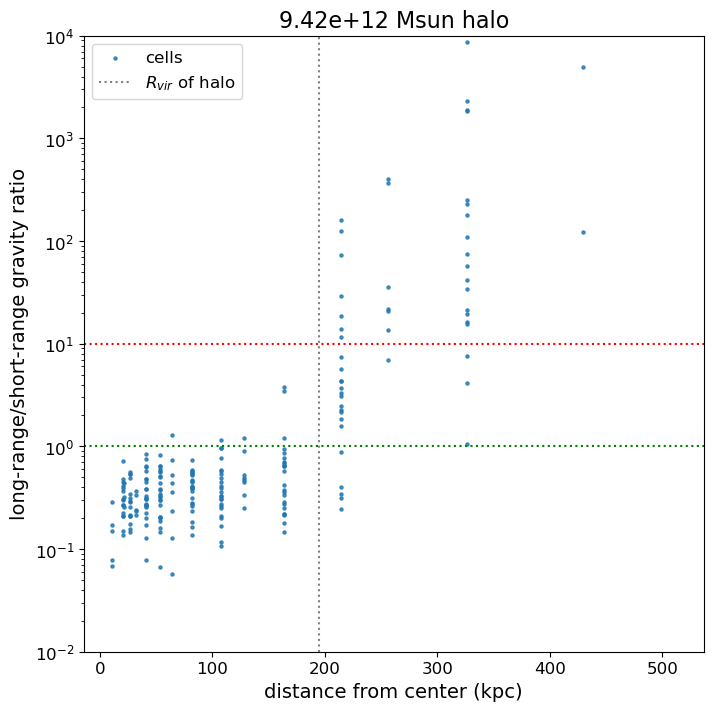

In [10]:
def sr_lr_comparison(
    cell_coords, sr_grid, lr_grid,
    Rvir, Mvir
    ):

    # Halo parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()
    grid_dist = grid_dist[dist_order]

    # Order short-range and long-range magnitudes.
    sr_mags = np.sqrt(np.sum(sr_grid**2, axis=1))
    lr_mags = np.sqrt(np.sum(lr_grid**2, axis=1))
    sr_mags = sr_mags[dist_order]
    lr_mags = lr_mags[dist_order]

    sr_mags[sr_mags == 0] = 1

    grav_ratio = lr_mags / sr_mags
    # grav_ratio = sr_mags / lr_mags
    print(f'min/max: {grav_ratio.min():.2e}/{grav_ratio.max():.2e}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('long-range/short-range gravity ratio')

    ax.set_ylim(1e-2,1e4)
    ax.set_yscale('log')
    plt.legend()
    plt.show()


sr_lr_comparison(
    cell_coords, gravity_sr, gravity_lr,
    halo_rvir, halo_Mvir
)

## NFW comparison.

In [11]:
def gravity_comparison_NFW(cell_coords, dPsi_grid, Rvir, Mvir, cNFW, z=0):

    # NFW parameters.
    Rvir *= kpc
    Mvir *= 10**Mvir*Msun
    Rs = Rvir/cNFW
    rho0 = fct.scale_density_NFW(z, cNFW)

    # Calculate NFW value at cell coords.
    NFW_cells = np.array([
        fct.dPsi_dxi_NFW(x_i, z, rho0, Mvir, Rvir, Rs, 'HALO')
        for x_i in cell_coords
    ])/(kpc/s**2)
    NFW_mags = np.sqrt(np.sum(NFW_cells**2, axis=1))

    # Magnitudes of gravity in each cell.
    dPsi_mags = np.sqrt(np.sum(dPsi_grid**2, axis=1))/(kpc/s**2)

    # Sort cells by distance from center (0,0,0).
    pos_grid = cell_coords/kpc
    grid_dist = np.sqrt(np.sum(pos_grid**2, axis=1))
    dist_order = grid_dist.argsort()

    grid_dist = grid_dist[dist_order]
    dPsi_mags = dPsi_mags[dist_order]
    NFW_mags = NFW_mags[dist_order]

    grav_ratio = dPsi_mags/NFW_mags
    print(f'dPsi/NFW: min={np.min(grav_ratio)}, max={np.max(grav_ratio)}')

    fig, ax = plt.subplots(1,1)

    ax.set_title(f'{Mvir/Msun:.2e} Msun halo')
    ax.scatter(
        grid_dist, grav_ratio, s=5, alpha=0.8, 
        label=f'cells'
    )
    ax.axhline(1, c='green', ls=':')
    ax.axhline(10, c='red', ls=':')
    ax.axhline(np.min(grav_ratio), c='red', ls=':')
    ax.axvline(
        Rvir/kpc, c='black', ls=':', alpha=0.5, 
        label=r'$R_{vir}$ of halo'
    )

    ax.set_xlabel('distance from center (kpc)')
    ax.set_ylabel('sim/NFW gravity ratio')

    ax.set_yscale('log')
    plt.legend()
    plt.show()

dPsi/NFW: min=0.0, max=13.453942125091569


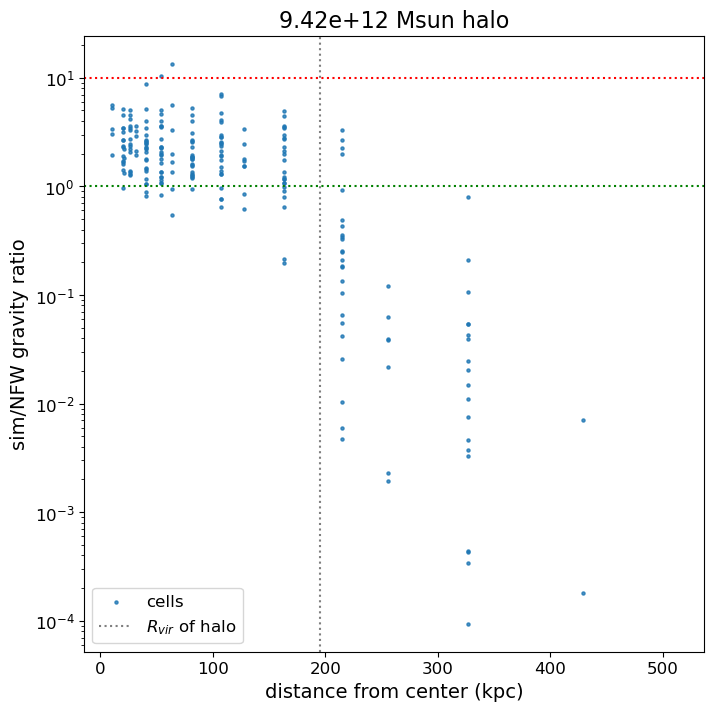

dPsi/NFW: min=0.38008252910418483, max=0.8822426352323035


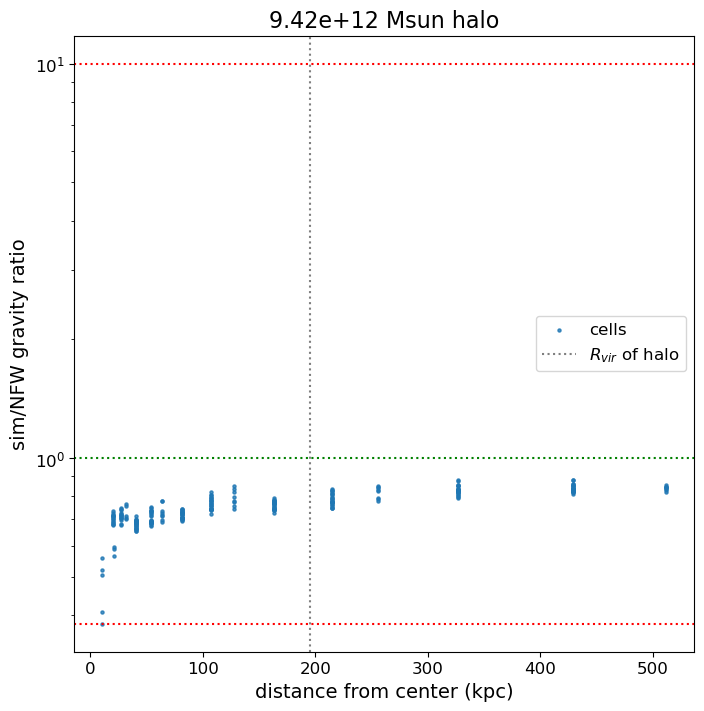

dPsi/NFW: min=0.7536324742419703, max=14.22449478779413


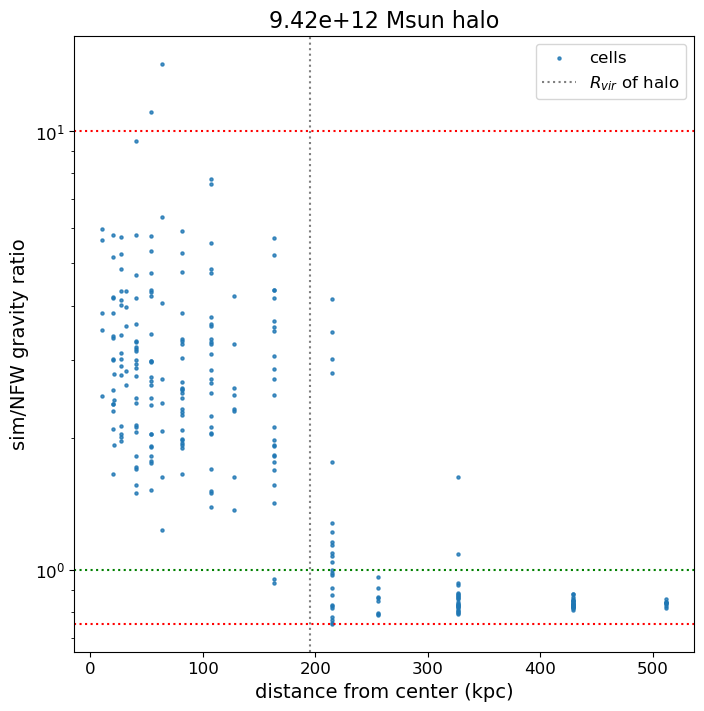

In [12]:
gravity_comparison_NFW(
    cell_coords, gravity_sr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)


gravity_comparison_NFW(
    cell_coords, gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)

gravity_comparison_NFW(
    cell_coords, gravity_sr+gravity_lr, 
    halo_rvir, halo_Mvir, halo_cNFW, z=0
)

## Directionality of gravity grid.

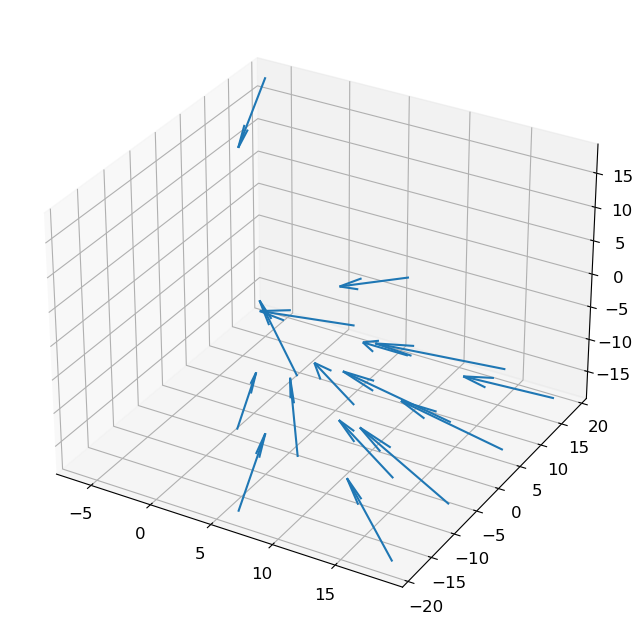

In [13]:
def grid_arrows(
    cell_coords, dPsi_grid,
):

    # x,y,z of cell coordinates.
    pos_grid = cell_coords/kpc
    xGrid = pos_grid[:,0]
    yGrid = pos_grid[:,1]
    zGrid = pos_grid[:,2]

    # x,y,z of gravity grid.
    xPsi = dPsi_grid[:,0]
    yPsi = dPsi_grid[:,1]
    zPsi = dPsi_grid[:,2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # start, stop = 0, -1 
    start, stop = 250, -1 
    ax.quiver(
        xGrid[start:stop], yGrid[start:stop], zGrid[start:stop], 
        xPsi[start:stop], yPsi[start:stop], zPsi[start:stop], 
        length=10, normalize=True
    )

    plt.show()


grid_arrows(cell_coords, gravity_lr)